<a href="https://colab.research.google.com/github/cbeckler/eco_cancer_incidence_rates/blob/main/Machine%20Learning%20Model/Balanced_random_forest_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,374 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main amd64 Packages [1,125 kB]
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:13 https://developer.download.nvidia.com/compute

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2023-01-20 20:25:47--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  1.59MB/s    in 0.6s    

2023-01-20 20:25:48 (1.59 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
# start spark session 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("balanced_random_forest").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#connect to database

import pandas as pd

conn_path = "/content/drive/MyDrive/Data/db_conn_info.csv"

conn_info = pd.read_csv(conn_path)

db_name = conn_info['db_name'][0]

db_pw = conn_info['password'][0]

db_host = conn_info['host'][0]

db_port = conn_info['port'][0]

db_user = conn_info['user'][0]

In [6]:
from sqlalchemy import create_engine

engine = create_engine(f'postgresql://{db_name}:{db_pw}@{db_host}:{db_port}/{db_user}')

In [7]:
# import model dataset

df = pd.read_sql("select * from model_dataset", engine)

df.head()

,index,FIPS,recent_trend,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred,PM25_max_pred_2001,...,O3_med_pred_2005,O3_med_pred_2006,O3_med_pred_2007,O3_med_pred_2008,O3_med_pred_2009,O3_med_pred_2010,O3_med_pred_2011,O3_med_pred_2012,O3_med_pred_2013,O3_med_pred_2014
0,0,01001,stable,12.239594,11.870589,11.787900,41.001571,39.948742,39.921898,13.186807,...,40.529218,43.681686,43.838816,40.486148,36.221797,41.289135,40.862455,39.302231,36.364677,37.080065
1,1,01003,stable,11.024418,9.822870,9.794272,45.070022,41.241604,41.341833,12.520190,...,43.565735,45.922312,43.525804,40.236525,38.505225,42.373774,42.022552,39.985824,37.438556,38.104659
2,2,01005,stable,11.688170,11.099414,11.084238,41.139416,40.185889,40.162437,12.364383,...,40.585246,43.720973,43.837824,41.187681,37.317680,41.459194,41.776717,39.300123,36.652613,37.449995
3,3,01007,stable,12.280141,11.700512,11.721958,40.505549,39.399455,39.389288,13.944184,...,41.133554,43.764713,43.850361,39.875838,35.059151,39.827738,39.680734,38.873873,35.961584,36.127933
4,4,01009,stable,13.498799,12.690525,12.741736,42.714107,41.096201,41.085945,16.032861,...,41.301827,43.677824,45.038788,41.869574,37.462589,42.542686,41.728563,41.646953,37.739042,38.077132


In [8]:
import numpy as np
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


## Create Features and target variable

In [9]:
X = df.drop(['index', 'FIPS', 'recent_trend'], axis=1)
y = df['recent_trend']

In [10]:
y.value_counts()

stable     2410
falling     198
rising       43
Name: recent_trend, dtype: int64

## Data split into Training and Testing

In [11]:
#Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)
scaler =StandardScaler().fit(X_train)

X_train_scaled =scaler.transform(X_train)
X_test_scaled =scaler.transform(X_test)

## Data resampled with SMOTE

In [12]:
# Resampling training data with SMOTE
X_resampled, y_resampled = SMOTE(
    random_state=1,sampling_strategy='auto').fit_resample(
    X_train_scaled, y_train)

print(f'y_resampled: {Counter(y_resampled)}')

y_resampled: Counter({'stable': 1807, 'falling': 1807, 'rising': 1807})


## Balanced Random Forest Classifier 

In [13]:
from imblearn.ensemble import BalancedRandomForestClassifier
brc=BalancedRandomForestClassifier(random_state=1, n_estimators=100).fit(X_resampled, y_resampled)

In [14]:
y_pred= brc.predict(X_test_scaled)

In [15]:
y_pred_train= brc.predict(X_train_scaled)

## Balanced Accuracy Score

In [16]:
# Balanced accuracy training score 
balanced_accuracy_score(y_train, y_pred_train)

1.0

In [17]:
# Balanced accuracy testign score
balanced_accuracy_score(y_test, y_pred)


0.3670874651684886

## Confusion Matrix

In [18]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[ 10,   1,  38],
       [  0,   0,  11],
       [ 45,  17, 541]])

In [19]:
brc_df=pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
brc_df.head()

,Prediction,Actual
0,stable,stable
1,stable,stable
2,stable,stable
3,stable,stable
4,stable,stable


In [20]:
print(brc_df.Prediction.value_counts())
print(brc_df.Actual.value_counts())

stable     590
falling     55
rising      18
Name: Prediction, dtype: int64
stable     603
falling     49
rising      11
Name: Actual, dtype: int64


## Imbalanced Classification Report

In [21]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

    falling       0.18      0.20      0.93      0.19      0.43      0.18        49
     rising       0.00      0.00      0.97      0.00      0.00      0.00        11
     stable       0.92      0.90      0.18      0.91      0.41      0.18       603

avg / total       0.85      0.83      0.25      0.84      0.40      0.17       663



# Predictions with trained model 

In [22]:
scaler =StandardScaler().fit(X)
X_scaled =scaler.transform(X)

In [23]:
prediction_trend= brc.predict(X_scaled)

In [24]:
prediction_trend

array(['stable', 'stable', 'stable', ..., 'stable', 'stable', 'stable'],
      dtype=object)

In [25]:
df.head()
# df.to_csv('/content/drive/MyDrive/Final_Project/df.csv')

,index,FIPS,recent_trend,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred,PM25_max_pred_2001,...,O3_med_pred_2005,O3_med_pred_2006,O3_med_pred_2007,O3_med_pred_2008,O3_med_pred_2009,O3_med_pred_2010,O3_med_pred_2011,O3_med_pred_2012,O3_med_pred_2013,O3_med_pred_2014
0,0,01001,stable,12.239594,11.870589,11.787900,41.001571,39.948742,39.921898,13.186807,...,40.529218,43.681686,43.838816,40.486148,36.221797,41.289135,40.862455,39.302231,36.364677,37.080065
1,1,01003,stable,11.024418,9.822870,9.794272,45.070022,41.241604,41.341833,12.520190,...,43.565735,45.922312,43.525804,40.236525,38.505225,42.373774,42.022552,39.985824,37.438556,38.104659
2,2,01005,stable,11.688170,11.099414,11.084238,41.139416,40.185889,40.162437,12.364383,...,40.585246,43.720973,43.837824,41.187681,37.317680,41.459194,41.776717,39.300123,36.652613,37.449995
3,3,01007,stable,12.280141,11.700512,11.721958,40.505549,39.399455,39.389288,13.944184,...,41.133554,43.764713,43.850361,39.875838,35.059151,39.827738,39.680734,38.873873,35.961584,36.127933
4,4,01009,stable,13.498799,12.690525,12.741736,42.714107,41.096201,41.085945,16.032861,...,41.301827,43.677824,45.038788,41.869574,37.462589,42.542686,41.728563,41.646953,37.739042,38.077132


In [26]:
df['prediction_trend'] = prediction_trend

print(df.recent_trend.value_counts())
print(df.prediction_trend.value_counts())

stable     2410
falling     198
rising       43
Name: recent_trend, dtype: int64
stable     2393
falling     207
rising       51
Name: prediction_trend, dtype: int64


## Feature importances

In [27]:
# List the features sorted in descending order by feature importance
features = sorted(zip(X.columns, brc.feature_importances_), reverse= True, key = lambda x: x[1])
for feature in features:
    print(f'{feature[0]}:{feature[1]}')

O3_mean_pred_2006:0.024982831011226298
O3_med_pred_2006:0.024548918880973644
O3_mean_pred_2009:0.018851113428640782
O3_max_pred_2002:0.018617212563745687
O3_max_pred_2006:0.018349849688384892
O3_med_pred_2003:0.018258171890670017
O3_mean_pred_2003:0.018151429386559333
O3_med_pred_2009:0.0169095164069438
O3_mean_pred_2005:0.016837424077123027
O3_max_pred_2009:0.016750841814768935
O3_max_pred_2004:0.01663712205692336
O3_max_pred:0.01648083602805428
O3_med_pred_2005:0.016305453295457142
O3_max_pred_2008:0.015756849678215598
O3_mean_pred:0.015284231405069472
O3_max_pred_2001:0.0148419463358256
PM25_max_pred_2007:0.014590115396760627
O3_med_pred_2011:0.014219058253237505
O3_med_pred_2004:0.014209338514100297
O3_med_pred:0.014065102069459951
O3_mean_pred_2011:0.013756745273528711
O3_max_pred_2005:0.013591334891312657
O3_med_pred_2013:0.013482366649668757
PM25_max_pred_2011:0.01342397331271523
O3_max_pred_2013:0.012899206663697649
O3_mean_pred_2004:0.012876377499225941
O3_mean_pred_2010:0.012

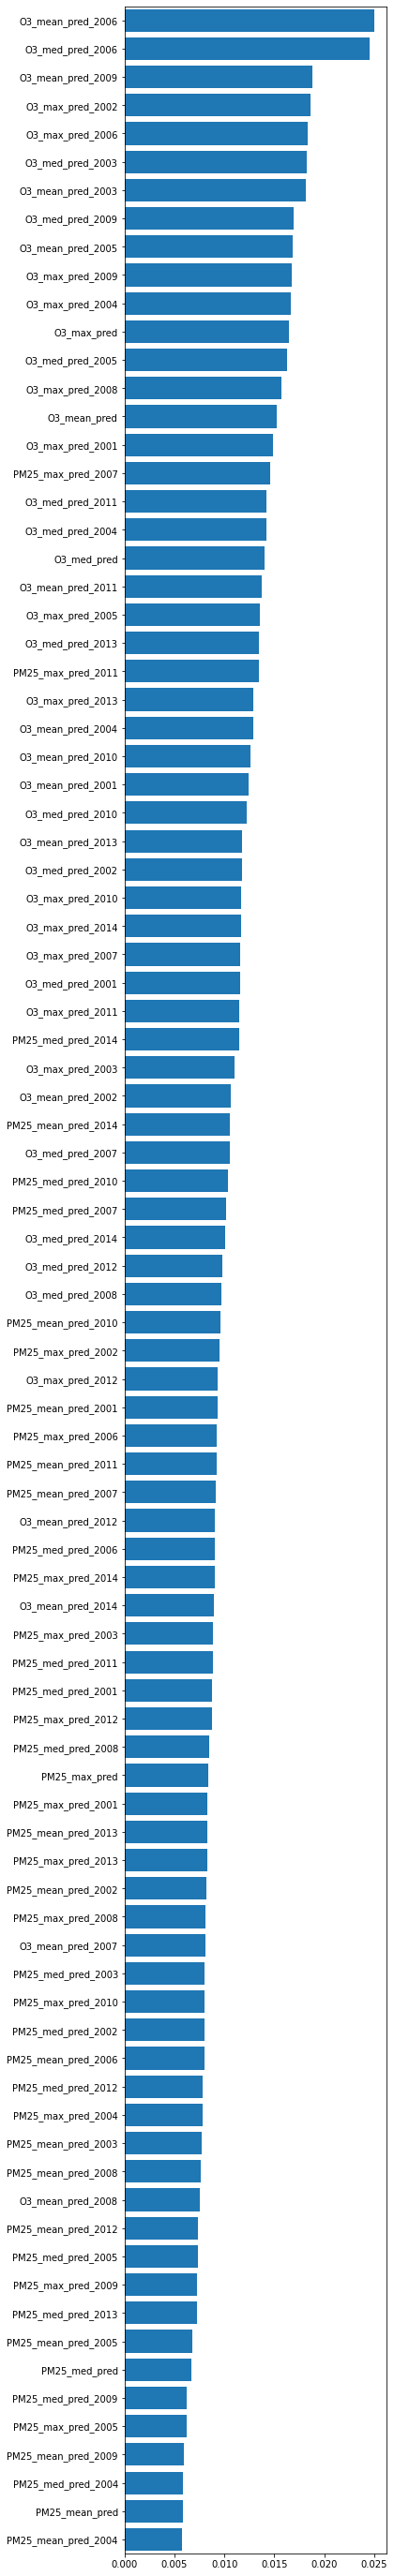

In [28]:
import matplotlib.pyplot as plt
features = sorted(zip(X.columns, brc.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(5,50)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)
plt.savefig('/content/drive/MyDrive/Final_Project/Feature_Importances')
plt.show()

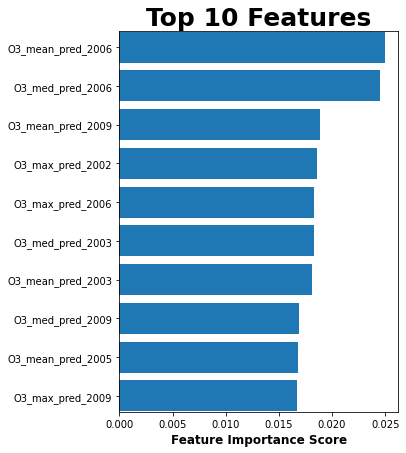

In [29]:
# graph with top 10 features
features = sorted(zip(X.columns, brc.feature_importances_), key = lambda x: x[1])

features_df = pd.DataFrame(features, columns=['feature', 'score'])

features_df = features_df.sort_values(by='score', ascending=False)

top_features = features_df.head(10)

top_features = top_features.sort_values(by='score')

cols = top_features['feature']
width = top_features['score']

fig, ax = plt.subplots()

fig.set_size_inches(5,7)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

ax.set_title("Top 10 Features",fontdict={'fontsize': 25, 'fontweight': 'semibold'})
ax.set_xlabel("Feature Importance Score",fontdict={'fontsize': 12, 'fontweight': 'semibold'})

plt.savefig('/content/drive/MyDrive/Final_Project/Feature_Importances_top10')
plt.show()

In [30]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    brc, X_test_scaled, y_test, n_repeats=10, random_state=1, n_jobs=2)

forest_importances = pd.Series(result.importances_mean)

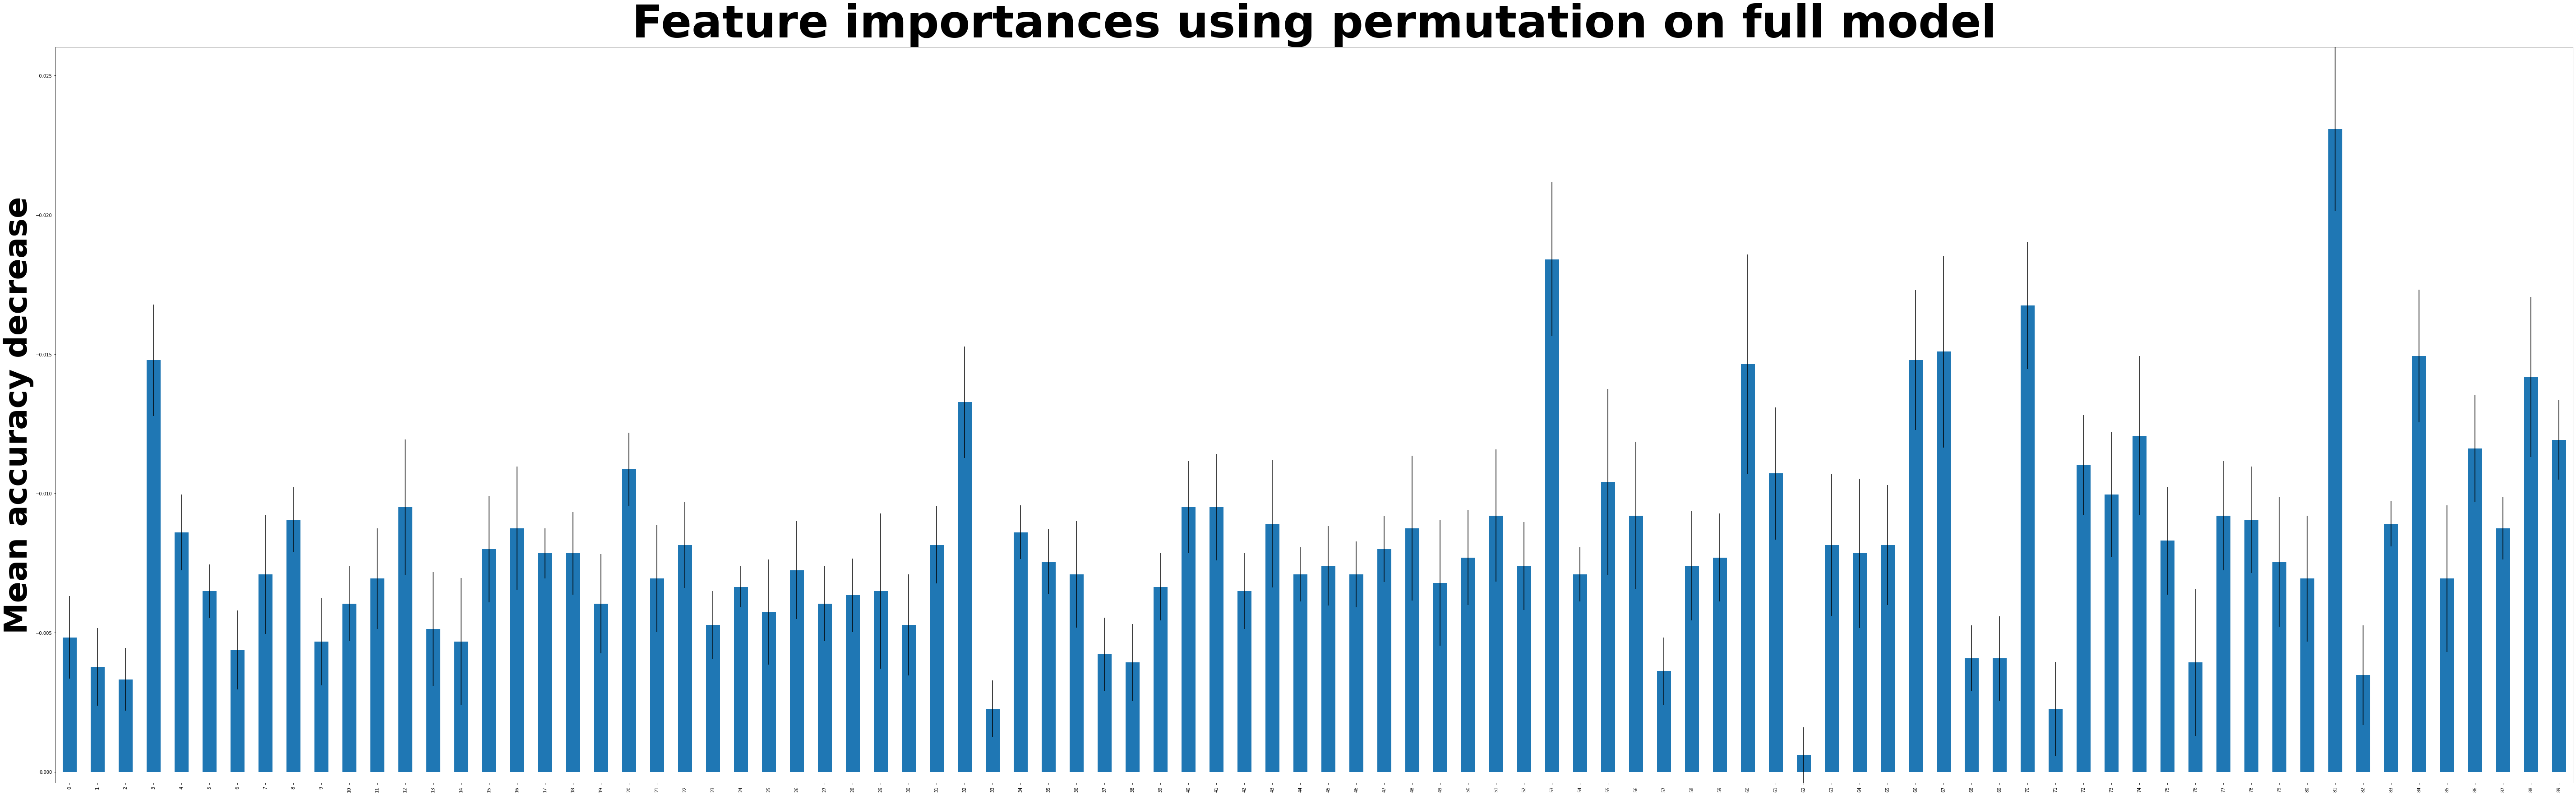

In [31]:
import matplotlib.pylab as pylab

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model",fontdict={'fontsize': 100, 'fontweight': 'semibold'})
ax.set_ylabel("Mean accuracy decrease",fontdict={'fontsize': 70, 'fontweight': 'semibold'})
ax.invert_yaxis()
fig.set_size_inches(100,30)
plt.margins(x=0.00001,y=0.00001)


plt.savefig('/content/drive/MyDrive/Final_Project/Forest_Importances')
plt.show()

In [32]:
# export data for visualizations

viz_cols = ['FIPS', 'recent_trend', 'prediction_trend', 'O3_max_pred', 'PM25_max_pred']

viz_df = df[viz_cols].copy()

viz_df.head()

,FIPS,recent_trend,prediction_trend,O3_max_pred,PM25_max_pred
0,01001,stable,stable,41.001571,12.239594
1,01003,stable,stable,45.070022,11.024418
2,01005,stable,stable,41.139416,11.688170
3,01007,stable,stable,40.505549,12.280141
4,01009,stable,stable,42.714107,13.498799


In [33]:
viz_df.to_sql('visualization_data', engine, if_exists='replace', index=False)